In [1]:
!pip install pandas numpy matplotlib boto3 kubernetes PyYAML

In [2]:
import glob
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.use('tkAgg')

In [3]:
%matplotlib inline

In [4]:
%cd /mnt/Jonas/Projetos/Artigos/1_Artigo/

[WinError 3] O sistema não pode encontrar o caminho especificado: '/mnt/Jonas/Projetos/Artigos/1_Artigo/'
e:\Projetos\Artigos\1_Artigo\testes


C:\Users\JonasCGN\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [5]:
def obter_arquivos_statistics(base_dir):
    pattern = f"{base_dir}/**/statistics.csv"
    return glob.glob(pattern, recursive=True)  

def _to_float(value) -> float:
    try:
        return float(str(value))
    except ValueError:
        return 0.1

In [6]:
arquivos = obter_arquivos_statistics('simulation')
por_data_hora = defaultdict(list)

for arquivo in arquivos:
    partes = arquivo.split(os.sep)
    if len(partes) >= 5:
        data = f"{partes[1]}/{partes[2]}/{partes[3]}"  # YYYY/MM/DD
        hora = partes[4]  # HHMMSS
        chave = f"{data} {hora}"
        por_data_hora[chave].append(arquivo)

In [7]:

resultados = []

for chave, lista in por_data_hora.items():
    data, hora = chave.split()
    if len(lista) >= 3:
        for arq in lista:
            df = pd.read_csv(arq)
            nome_simulacao = os.path.basename(os.path.dirname(arq))
            metricas = dict(zip(df.iloc[:,0], df.iloc[:,1]))
            if "duration_hours" in metricas and "total_downtime" in metricas:
                duracao = metricas["duration_hours"]
                downtime = metricas["total_downtime"]
                disponibilidade = (1 - (_to_float(downtime) / _to_float(duracao))) * 100
                mean_recovery_time = metricas.get("mean_recovery_time", None)
                resultados.append({
                    "Simulação": nome_simulacao,
                    "Data": data,
                    "Hora": hora,
                    "Duração (h)": duracao,
                    "Downtime (h)": downtime,
                    "Disponibilidade (%)": disponibilidade,
                    "Mean Recovery Time": mean_recovery_time
                })
        if resultados:
            df_resultados = pd.DataFrame(resultados)

            # Gráfico de disponibilidade por simulação
            plt.figure()
            plt.plot(df_resultados["Simulação"].str.extract(r'(\d+)')[0].astype(int), df_resultados["Disponibilidade (%)"], marker='o')
            plt.xticks(df_resultados["Simulação"].str.extract(r'(\d+)')[0].astype(int)) 
            plt.title("Disponibilidade por Simulação")
            plt.xlabel("Iteração")
            plt.ylabel("Disponibilidade (%)")
            # Define o limite inferior do eixo y como o mínimo arredondado para baixo (sempre pra menos)
            plt.ylim(np.floor(df_resultados["Disponibilidade (%)"].min()*100)/100, 100) 
            plt.xticks(rotation=45)
            plt.tight_layout()
            # plt.savefig("disponibilidade_por_simulacao.png")
            # plt.show()

            # Gráfico de mean_recovery_time por simulação
            plt.figure()
            plt.plot(df_resultados["Simulação"], df_resultados["Mean Recovery Time"], marker='o', color='orange')
            plt.title("Mean Recovery Time por Simulação")
            plt.xlabel("Iteração")
            plt.ylabel("Mean Recovery Time (s)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            # plt.savefig("mean_recovery_time_por_simulacao.png")
            # plt.show()

            print(df_resultados.to_string(index=False))
            resultados = []

In [8]:

arquivos = obter_arquivos_statistics('simulation')
por_data_hora = defaultdict(list)

for arquivo in arquivos:
    partes = arquivo.split(os.sep)
    if len(partes) >= 5:
        data = f"{partes[1]}/{partes[2]}/{partes[3]}"  # YYYY/MM/DD
        hora = partes[4]  # HHMMSS
        chave = f"{data} {hora}"
        por_data_hora[chave].append(arquivo)

resultados = []
all_results = []

for chave, lista in por_data_hora.items():
    data, hora = chave.split()
    if len(lista) >= 3:
        for arq in lista:
            df = pd.read_csv(arq)
            nome_simulacao = os.path.basename(os.path.dirname(arq))
            metricas = dict(zip(df.iloc[:,0], df.iloc[:,1]))
            if "duration_hours" in metricas and "total_downtime" in metricas:
                duracao = metricas["duration_hours"]
                downtime = metricas["total_downtime"]
                disponibilidade = (1 - (_to_float(downtime) / _to_float(duracao))) * 100
                mean_recovery_time = metricas.get("mean_recovery_time", None)
                resultados.append({
                    "Simulação": nome_simulacao,
                    "Data": data,
                    "Hora": hora,
                    "Duração (h)": duracao,
                    "Downtime (h)": downtime,
                    "Disponibilidade (%)": disponibilidade,
                    "Mean Recovery Time": mean_recovery_time
                })
                
        if resultados:
            index = 0
            df_resultados = pd.DataFrame(resultados)

            # print(df_resultados.to_string(index=False))
            all_results.append(resultados)
            
            index += 1
            resultados = []
            
# Combine all mean recovery times into a single DataFrame for display
tabelas = []
for res in all_results:
    df_resultados = pd.DataFrame(res)
    mean_recovery = df_resultados['Mean Recovery Time'].mean()
    std_recovery = df_resultados['Mean Recovery Time'].std()
    mean_disponibilidade = df_resultados['Disponibilidade (%)'].mean()
    std_disponibilidade = df_resultados['Disponibilidade (%)'].std()
    mean_downtime = df_resultados['Downtime (h)'].mean()
    std_downtime = df_resultados['Downtime (h)'].std()
    tabelas.append({
        "Data": df_resultados["Data"].iloc[0],
        "Hora": df_resultados["Hora"].iloc[0],
        "N_Iteracoes": len(df_resultados),
        "Mean Recovery Time (média ±σ )": f"{mean_recovery:.2f} (±{std_recovery:.2f})",
        "Dispobinilidade (Média)": f"{mean_disponibilidade:.2f} (±{std_disponibilidade:.2f})",
        "Downtime (h) (Média)": f"{mean_downtime:.2f} (±{std_downtime:.2f})"
    })
tabela_final = pd.DataFrame(tabelas)
display(tabela_final)

""


In [9]:
# Análise de disponibilidade por quantidade de worker nodes
import json

def obter_arquivos_statistics_disponibilidade(base_dir):
    """Obtém arquivos statistics.csv da pasta disponibilidade"""
    pattern = f"{base_dir}/**/statistics.csv"
    return glob.glob(pattern, recursive=True)

def extrair_num_worker_nodes(caminho):
    """Extrai o número de worker nodes do caminho"""
    partes = caminho.split(os.sep)
    for parte in partes:
        if parte in ['1', '2', '3', '4', '5']:  # Assumindo até 5 worker nodes
            return int(parte)
    return None

def calcular_disponibilidade_custom(duration_hours, total_downtime):
    """Calcula disponibilidade usando duration_hours - total_downtime"""
    duracao = _to_float(duration_hours)
    downtime = _to_float(total_downtime)
    tempo_disponivel = duracao - downtime
    disponibilidade = (tempo_disponivel / duracao) * 100
    return disponibilidade

# Obter arquivos da pasta disponibilidade
import os
os.chdir(r'E:\Projetos\Artigos\1_Artigo')
arquivos_disp = obter_arquivos_statistics_disponibilidade('disponibilidade')
resultados_por_workers = defaultdict(list)

print("Arquivos encontrados:")
for arq in arquivos_disp:
    print(f"  {arq}")
    
print(f"\nTotal de arquivos: {len(arquivos_disp)}")

Arquivos encontrados:
  disponibilidade\1\ITERACAO1\statistics.csv
  disponibilidade\2\ITERACAO5\statistics.csv
  disponibilidade\3\ITERACAO1\statistics.csv

Total de arquivos: 3


In [10]:
# Processar dados de disponibilidade por worker nodes
for arquivo in arquivos_disp:
    num_workers = extrair_num_worker_nodes(arquivo)
    if num_workers is not None:
        try:
            df = pd.read_csv(arquivo)
            metricas = dict(zip(df.iloc[:,0], df.iloc[:,1]))
            
            if "duration_hours" in metricas and "total_downtime" in metricas:
                # Usar o cálculo personalizado: duration_hours - total_downtime
                disponibilidade = calcular_disponibilidade_custom(
                    metricas["duration_hours"], 
                    metricas["total_downtime"]
                )
                
                # Também extrair outras métricas úteis
                mean_recovery_time = metricas.get("mean_recovery_time", None)
                total_failures = metricas.get("total_failures", None)
                
                resultados_por_workers[num_workers].append({
                    "arquivo": arquivo,
                    "disponibilidade": disponibilidade,
                    "duration_hours": metricas["duration_hours"],
                    "total_downtime": metricas["total_downtime"],
                    "mean_recovery_time": mean_recovery_time,
                    "total_failures": total_failures
                })
        except Exception as e:
            print(f"Erro ao processar {arquivo}: {e}")

# Exibir resumo dos dados coletados
print("\n=== Resumo dos dados coletados ===")
for num_workers in sorted(resultados_por_workers.keys()):
    dados = resultados_por_workers[num_workers]
    print(f"\n{num_workers} Worker Node(s): {len(dados)} iterações")
    for i, item in enumerate(dados, 1):
        print(f"  Iteração {i}: {item['disponibilidade']:.2f}% de disponibilidade")


=== Resumo dos dados coletados ===

1 Worker Node(s): 1 iterações
  Iteração 1: 99.47% de disponibilidade

2 Worker Node(s): 1 iterações
  Iteração 1: 99.27% de disponibilidade

3 Worker Node(s): 1 iterações
  Iteração 1: 98.07% de disponibilidade


In [11]:
# Calcular estatísticas por número de worker nodes
estatisticas_resumo = []
dados_para_grafico = []

for num_workers in sorted(resultados_por_workers.keys()):
    dados = resultados_por_workers[num_workers]
    disponibilidades = [item['disponibilidade'] for item in dados]
    
    if disponibilidades:
        media_disp = np.mean(disponibilidades)
        std_disp = np.std(disponibilidades)
        min_disp = np.min(disponibilidades)
        max_disp = np.max(disponibilidades)
        
        estatisticas_resumo.append({
            "Worker Nodes": num_workers,
            "Iterações": len(disponibilidades),
            "Disponibilidade Média (%)": f"{media_disp:.2f}",
            "Desvio Padrão": f"{std_disp:.2f}",
            "Min (%)": f"{min_disp:.2f}",
            "Max (%)": f"{max_disp:.2f}",
            "Média ± DP": f"{media_disp:.2f} ± {std_disp:.2f}"
        })
        
        # Preparar dados para gráfico (cada ponto individual)
        for disp in disponibilidades:
            dados_para_grafico.append({
                "Worker Nodes": num_workers,
                "Disponibilidade": disp
            })

# Exibir tabela resumo
df_resumo = pd.DataFrame(estatisticas_resumo)
print("=== Estatísticas Resumo ===")
display(df_resumo)

=== Estatísticas Resumo ===


,Worker Nodes,Iterações,Disponibilidade Média (%),Desvio Padrão,Min (%),Max (%),Média ± DP
0,1,1,99.47,0.00,99.47,99.47,99.47 ± 0.00
1,2,1,99.27,0.00,99.27,99.27,99.27 ± 0.00
2,3,1,98.07,0.00,98.07,98.07,98.07 ± 0.00


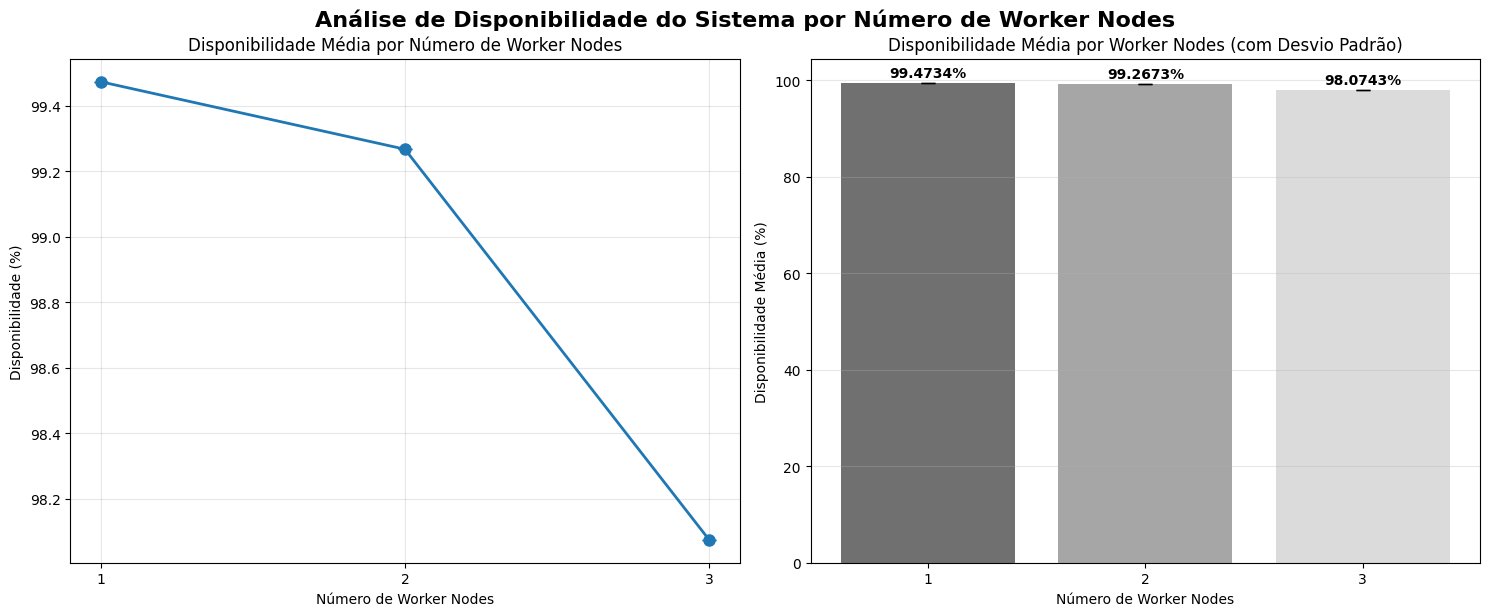

In [ ]:
# Criar gráficos de disponibilidade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de linha com média e desvio padrão
worker_nodes_list = []
medias = []
desvios = []

for num_workers in sorted(resultados_por_workers.keys()):
    dados = resultados_por_workers[num_workers]
    disponibilidades = [item['disponibilidade'] for item in dados]
    worker_nodes_list.append(num_workers)
    medias.append(np.mean(disponibilidades))
    desvios.append(np.std(disponibilidades))

ax1.errorbar(worker_nodes_list, medias, yerr=desvios, marker='o', capsize=5, linewidth=2, markersize=8)
ax1.set_xlabel('Número de Worker Nodes')
ax1.set_ylabel('Disponibilidade (%)')
ax1.set_title('Disponibilidade Média por Número de Worker Nodes')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(worker_nodes_list)

# 2. Box plot
df_grafico = pd.DataFrame(dados_para_grafico)
worker_nodes_unique = sorted(df_grafico['Worker Nodes'].unique())
dados_boxplot = [df_grafico[df_grafico['Worker Nodes'] == wn]['Disponibilidade'].values 
                for wn in worker_nodes_unique]

# Escala de cinza para as barras
gray_colors = [str(0.2 + 0.6*i/(len(worker_nodes_list)-1)) for i in range(len(worker_nodes_list))] if len(worker_nodes_list) > 1 else ['0.5']

# 4. Gráfico de barras com média
ax2.bar(worker_nodes_list, medias, yerr=desvios, capsize=5, alpha=0.7, color=gray_colors)
ax2.set_xlabel('Número de Worker Nodes')
ax2.set_ylabel('Disponibilidade Média (%)')
ax2.set_title('Disponibilidade Média por Worker Nodes (com Desvio Padrão)')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(worker_nodes_list)

# Adicionar valores nas barras
for i, (x, y, err) in enumerate(zip(worker_nodes_list, medias, desvios)):
    ax2.text(x, y + err + 0.5, f'{y:.4f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Análise de Disponibilidade do Sistema por Número de Worker Nodes', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [13]:
"""
10/11/2025

1 - Gerar um grafico dos resultados atuais. 
Fazer media e desvio padrão dos dados. Fazeer alguns boxplot


2 - Vou rodar ele, desconsiderando o tempo de procura de pods. 
se 
    deu igual, tanto faz. 
diferente, 
    roda denovo. 

3 - Quando nao for self healing, usa o valor do mttr(ficticio).
shutdown e ligar depois(usar valor do mttr ficticio(mas roda o tempo de delay))

"""

'\n10/11/2025\n\n1 - Gerar um grafico dos resultados atuais. \nFazer media e desvio padrão dos dados. Fazeer alguns boxplot\n\n\n2 - Vou rodar ele, desconsiderando o tempo de procura de pods. \nse \n    deu igual, tanto faz. \ndiferente, \n    roda denovo. \n\n3 - Quando nao for self healing, usa o valor do mttr(ficticio).\nshutdown e ligar depois(usar valor do mttr ficticio(mas roda o tempo de delay))\n\n'

In [14]:
"""

1 - Fazer metodo shutdown control-plane

3 - 5 Interações

"""

"""

Criar um README configuracoes inicias e como usar e valores padrao caso nao ache

-> Chama get-config -> Fazer o teste(get-config-all)(Pegar os mttrs) -> get de disponibilidade

-> Criar uma classe exemplo (Vai ter so os metodos acima)

"""

'\n\nCriar um README configuracoes inicias e como usar e valores padrao caso nao ache\n\n-> Chama get-config -> Fazer o teste(get-config-all)(Pegar os mttrs) -> get de disponibilidade\n\n-> Criar uma classe exemplo (Vai ter so os metodos acima)\n\n'